# spectra_post 
Jupyter notebook for post processing spectra files from WinSpec

Uses spectroscopy.py library
written by Peter Ningren Han;
modified by Nili Persits and Jaehwan Kim.

[1.38671 1.38754]
[1.72909 1.73113]


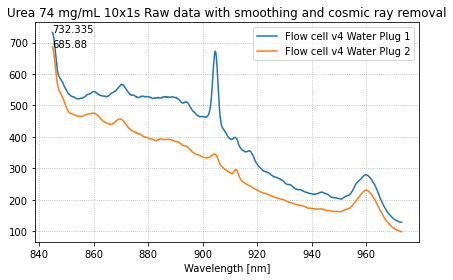

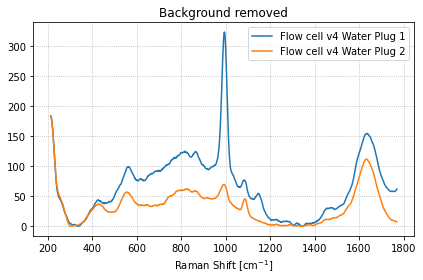

In [1]:
%reset -f

import matplotlib.pyplot as plt
from speclib.spectroscopy import *
# analyte = '70% Ethanol'
analyte = 'Urea 74 mg/mL'
laser=830.0
filename_dic = {
#     'Sample Holder':       './data/20210128 Flowcell v3 test/sample-holder_urea_10x1s8',
#     'Flow cell v2':        './data/20210125 Flowcell v2 test/Flow_cell_urea_10x1s1',
#     'Flow cell v2': './data/20210125 Flowcell v2 test/Flow_cell_ethanol70percemt_10x1s3',
#     'Flow cell v2.1\nscrews tightened':        './data/20210126 Flowcell v2 test 2/urea_10x1s10',
#     'Flow cell v2.1': './data/20210126 Flowcell v2 test 2/ethanol70pc_10x1s5',
    
#     'Flow cell v3 #1':       './data/20210128 Flowcell v3 test/FCv3_urea_10x1s1',    
#     'Flow cell v3 #2':       './data/20210128 Flowcell v3 test/FCv3_urea_10x1s2', 
    
    
#     'Flow cell v3 Open #1':       './data/20210129 Flowcell v3 test/FCv3Open_urea_10x1s16', # lower laser power 0.689
#     'Flow cell v3 Open #2':       './data/20210129 Flowcell v3 test/FCv3Open_urea_10x1s17', # 0.7
#     'Flow cell v3 Open #3':       './data/20210129 Flowcell v3 test/FCv3Open_urea_10x1s18', 
    
#     'Flow cell v4 Open #1':       './data/20210131 Flowcell v4 test/FCv4Open_urea_10x1s19',
#     'Flow cell v4 Open #2':       './data/20210131 Flowcell v4 test/FCv4Open_urea_10x1s20', 
    
    
#     'Flow cell v4 Urea21':       './data/20210131 Flowcell v4 test/FCv4_urea_10x1s21', 
#     'Flow cell v4 Urea22':       './data/20210131 Flowcell v4 test/FCv4_urea_10x1s22', 
#     'Flow cell v4 Urea+Ethanol trace':       './data/20210131 Flowcell v4 test/FCv4_urea_10x1s23', 
#     'Flow cell v4 Water Plug 1':       './data/20210131 Flowcell v4 test/FCv4_urea_10x1s24-water', 
#     'Flow cell v4 Water Plug 2':       './data/20210131 Flowcell v4 test/FCv4_urea_10x1s27', 
    
#     'Flow cell v4 Urea':       './data/20210131 Flowcell v4 test/FCv4_urea_10x1s28', 
    'Flow cell v4 Water Plug 1':       './data/20210131 Flowcell v4 test/FCv4_ureatest_10x1s29', 
    'Flow cell v4 Water Plug 2':       './data/20210131 Flowcell v4 test/FCv4_ureatest_10x1s30', 
}

data_dic = {}
for key, file_name in filename_dic.items():
    try:
        X, wave = load_txt_new(file_name=file_name, if_plot=False)
    except:
        X, wave = load_txt_auto(file_name=file_name, if_plot=False)
        
#     print(X.shape)
#     print(wave.shape)
    X_sig, X_bkg = background_remove_full(X, order=3, basis_type='poly', method='Lieber')    
    waveshift = wave_2_waveshift(wave, laser)
    
    data_dic[key] = [waveshift, X_sig[0], wave, X]


plt.figure()
for key, data in data_dic.items():
    plt.plot(data[2], data[3], label=key)
    peak = np.max(data[3])
    peak_wave = data[2][np.argmax(data[3])]
    SBR = peak / data[3][np.abs(data[2]-880.0)<0.1] # signal to background peak at 880nm
    print(SBR)
#     plt.annotate('Peak count: {:g}\nSignal to 880nm background: {:g}'.format(peak, np.mean(SBR)), xy=(data[2][np.argmax(data[3])], peak))
    plt.annotate('{:g}'.format(peak), xy=(peak_wave, peak))
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.grid(True, linestyle=':')
plt.title('{} 10x1s Raw data with smoothing and cosmic ray removal'.format(analyte))
plt.tight_layout()
plt.show()


plt.figure()
for key, data in data_dic.items():
    plt.plot(data[0], data[1], label=key)
plt.legend()
plt.xlabel('Raman Shift [cm$^{-1}$]')
plt.grid(True, linestyle=':')
plt.title('Background removed')
plt.tight_layout()
plt.show()


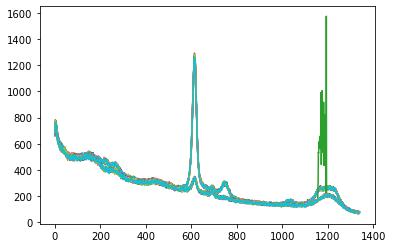

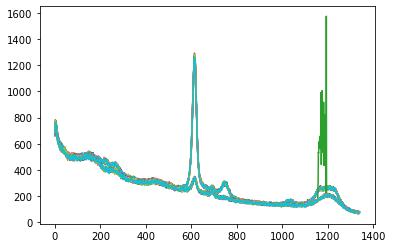

(array([[754.46147, 751.80445, 748.04576, ...,  76.52449,  76.29758,  76.04961],
        [720.15807, 718.11577, 714.96894, ...,  75.7543 ,  75.76933,  75.80592]]),
 0       844.886
 1       844.985
 2       845.084
 3       845.182
 4       845.281
          ...   
 1335    972.534
 1336    972.626
 1337    972.718
 1338    972.811
 1339    972.903
 Name: 1, Length: 1340, dtype: float64)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxopt

from scipy.interpolate import BSpline, splev, splrep
from scipy.ndimage.filters import median_filter
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from speclib.spectroscopy import *

directory = "~/Dropbox (MIT)/Biomod Spectra/Camp flow cell evaluation/Feb 03/"
filename='FCv5_test_10x1s49 urea 2cleanwithtflask3 tflask3'
fullpath = directory+filename


file_name = fullpath
acq_per_sample = 10
sg_win_len=31
sg_poly_order=3

load_txt_auto(file_name, sg_win_len=31, sg_poly_order=3, if_plot=True)
load_txt_auto_multi(file_name, sg_win_len=31, sg_poly_order=3, acq_per_sample=10, if_plot=True)

# df = pd.read_csv(file_name + '.txt', sep=',', header=None)

# wave = df.loc[df[0] == 1][1]
# X = df[2].values
# X_raw = X.reshape(X.shape[0]//wave.shape[0]//acq_per_sample, acq_per_sample, wave.shape[0])

# X = np.zeros((X.shape[0]//wave.shape[0]//acq_per_sample, wave.shape[0]))
# for i in range(X_raw.shape[0]):
#     X[i,:] = spectrum_average(X_raw[i, :30, :], sg_win_len=sg_win_len, sg_poly_order=sg_poly_order)
    





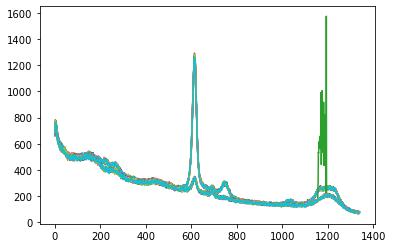

In [49]:
fig, ax = plt.subplots()
# ax.plot(X_raw[1].T)
ax.plot(X_raw.reshape(X_raw.shape[0]*X_raw.shape[1], X_raw.shape[2]).T)
plt.show()

In [ ]:
# 2021.02.04 LOD measurements
# 50x10s
# Fcv5_test_10x1s6
# tflask1: 0mmol tflask2: 0.78125mmol tflask3 1.5625mmol


# Fcv5_test_10x1s7
# tflask1: 3.125mmol tflask2: 6.25mmol tflask3 12.5mmol

# Fcv5_test_10x1s8
# tflask1: 25mmol tflask2: 50mmol tflask3 100mmol

[2.31684 2.32019]
[2.30952 2.31242]
[2.31278 2.31592]
[2.32236 2.32583]
[2.32227 2.32568]
[2.31824 2.32161]


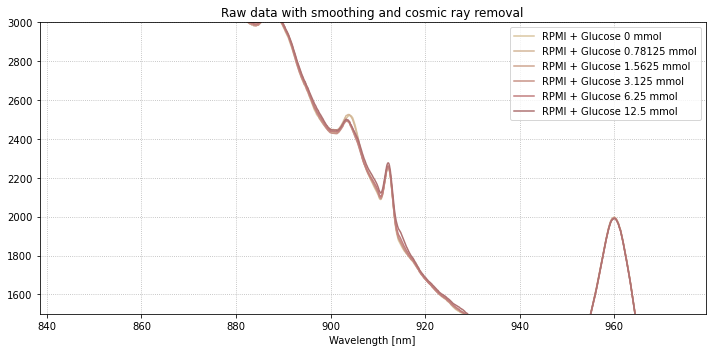

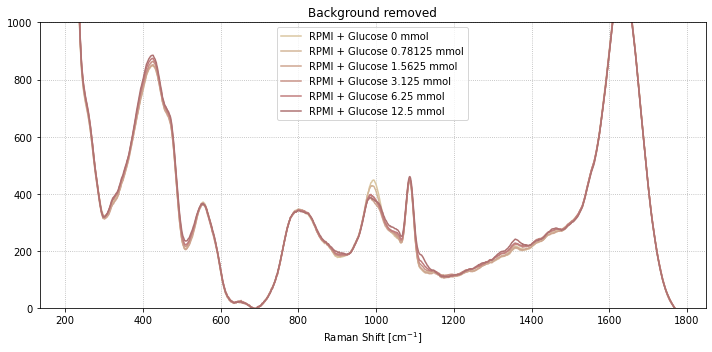

<built-in method items of dict object at 0x0000029E76B11C00>


In [46]:

import matplotlib.pyplot as plt
from speclib.spectroscopy import *
# analyte = '70% Ethanol'
# analyte = 'Urea 74 mg/mL'
analyte = 'RPMI with Glucose'
laser=830.0


directory = "~/Dropbox (MIT)/Biomod Spectra/Camp flow cell evaluation/Feb 04/FCv5_test_10x1s6"

# (filename, number of spectra, index)
filename_dic = {    
    'RPMI + Glucose 0 mmol':       ('~/Dropbox (MIT)/Biomod Spectra/Camp flow cell evaluation/Feb 04/FCv5_test_10x1s6', 50, 0), 
    'RPMI + Glucose 0.78125 mmol':       ('~/Dropbox (MIT)/Biomod Spectra/Camp flow cell evaluation/Feb 04/FCv5_test_10x1s6', 50, 1), 
    'RPMI + Glucose 1.5625 mmol':       ('~/Dropbox (MIT)/Biomod Spectra/Camp flow cell evaluation/Feb 04/FCv5_test_10x1s6', 50, 2), 
    'RPMI + Glucose 3.125 mmol':       ('~/Dropbox (MIT)/Biomod Spectra/Camp flow cell evaluation/Feb 04/FCv5_test_10x1s7', 50, 0), 
    'RPMI + Glucose 6.25 mmol':       ('~/Dropbox (MIT)/Biomod Spectra/Camp flow cell evaluation/Feb 04/FCv5_test_10x1s7', 50, 1), 
    'RPMI + Glucose 12.5 mmol':       ('~/Dropbox (MIT)/Biomod Spectra/Camp flow cell evaluation/Feb 04/FCv5_test_10x1s7', 50, 2), 
}

data_dic = {}
file_name = ''

for key, data_loc in filename_dic.items():    
    
    if file_name != data_loc[0]: # if new file load data
        file_name = data_loc[0]
        
        X_all, wave = load_txt_auto_multi(file_name=file_name, acq_per_sample = data_loc[1], if_plot=False)
    
    X = X_all[data_loc[2]]
    
        
#     print(X.shape)
#     print(wave.shape)
    X_sig, X_bkg = background_remove_full(X, order=3, basis_type='poly', method='Lieber')    
    waveshift = wave_2_waveshift(wave, laser)
    
    data_dic[key] = [waveshift, X_sig[0], wave, X]

plt.figure(figsize=(10,5))
color_idx = np.linspace(0.6, 0.3, len(data_dic))
i=0
for key, data in data_dic.items():    
    plt.plot(data[2], data[3], label=key, color=plt.cm.pink(color_idx[i]))
    peak = np.max(data[3])
    peak_wave = data[2][np.argmax(data[3])]
    SBR = peak / data[3][np.abs(data[2]-880.0)<0.1] # signal to background peak at 880nm
    print(SBR)
    
    i=i+1

#     plt.annotate('Peak count: {:g}\nSignal to 880nm background: {:g}'.format(peak, np.mean(SBR)), xy=(data[2][np.argmax(data[3])], peak))
#     plt.annotate('{:g}'.format(peak), xy=(peak_wave, peak))
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylim((1500,3000))
plt.grid(True, linestyle=':')
plt.title('Raw data with smoothing and cosmic ray removal')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,5))
i=0
for key, data in data_dic.items():
    plt.plot(data[0], data[1], label=key, color=plt.cm.pink(color_idx[i]))
    i = i+1
plt.ylim((0,1000))           
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend()
plt.xlabel('Raman Shift [cm$^{-1}$]')
plt.grid(True, linestyle=':')
plt.title('Background removed')
plt.tight_layout()
plt.show()

print(data_dic.items)

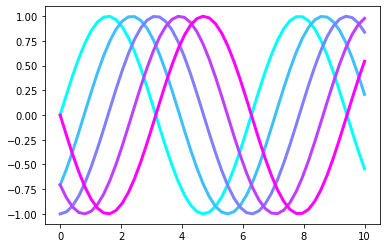

In [16]:
import numpy as np
import matplotlib.pyplot as plt

n_lines = 5
x = np.linspace(0, 10)
phase_shift = np.linspace(0, np.pi, n_lines)

color_idx = np.linspace(0, 1, n_lines)
for i, shift in zip(color_idx, phase_shift):
    plt.plot(x, np.sin(x - shift), color=plt.cm.cool(i), lw=3)

plt.show()